In [17]:
!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer


In [18]:
  !pip install triton


In [19]:
import re
import numpy as np
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Load and process the Paul Graham essays text
with open('/content/paul_graham_essays.txt', 'r') as file:
    text = file.read().lower()

# Remove special characters except for full stops

# Preprocess text
text = re.sub(r'http\S+', '', text)  # Remove URLs
text = re.sub(r'(\w)(\.)', r'\1 .', text)  # Separate periods attached to words or numbers
text = re.sub(r'[^a-zA-Z0-9 .]', ' ', text).lower()  # Keep only alphanumeric characters and periods
text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

# Tokenize the processed text
tokenizer = Tokenizer(filters='')  # Ensures no default filtering
tokenizer.fit_on_texts([text])

# Manually add period (.) if not present
if '.' not in tokenizer.word_index:
    tokenizer.word_index['.'] = len(tokenizer.word_index) + 1
stoi = tokenizer.word_index  # Word to index mapping
itos = {i: w for w, i in stoi.items()}  # Index to word mapping

# Tokenize text into words
words = text.split()

# Parameters
block_size = 5
X, Y = [], []

# Initialize context with full stops ('.')
context = [stoi.get('.', None)] * block_size

# Generate training pairs with the updated context
for i, word in enumerate(words):
    target = stoi.get(word, None)

    # Skip iteration if context or target has None
    if target is None or None in context:
        print(f"Skipping: Word '{word}' or context contains None.")
        continue

    X.append(list(context))  # Append a copy of the current context
    Y.append(target)

    # Print the first 20 context-target pairs for verification
    if i < 50:
        print(' '.join(itos[idx] for idx in context if idx is not None), '--->', itos.get(target, '?'))

    # Update context by shifting left and adding the current target
    context = context[1:] + [target]

# Convert to tensors for model input
import torch
X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

. . . . . ---> rss
. . . . rss ---> index
. . . rss index ---> .html
. . rss index .html ---> aaron
. rss index .html aaron ---> swartz
rss index .html aaron swartz ---> created
index .html aaron swartz created ---> a
.html aaron swartz created a ---> scraped
aaron swartz created a scraped ---> feed
swartz created a scraped feed ---> of
created a scraped feed of ---> the
a scraped feed of the ---> essays
scraped feed of the essays ---> page
feed of the essays page ---> .
of the essays page . ---> this
the essays page . this ---> year
essays page . this year ---> we
page . this year we ---> can
. this year we can ---> end
this year we can end ---> the
year we can end the ---> death
we can end the death ---> penalty
can end the death penalty ---> in
end the death penalty in ---> california
the death penalty in california ---> index
death penalty in california index ---> .html
penalty in california index .html ---> november
in california index .html november ---> 2016
california index .ht

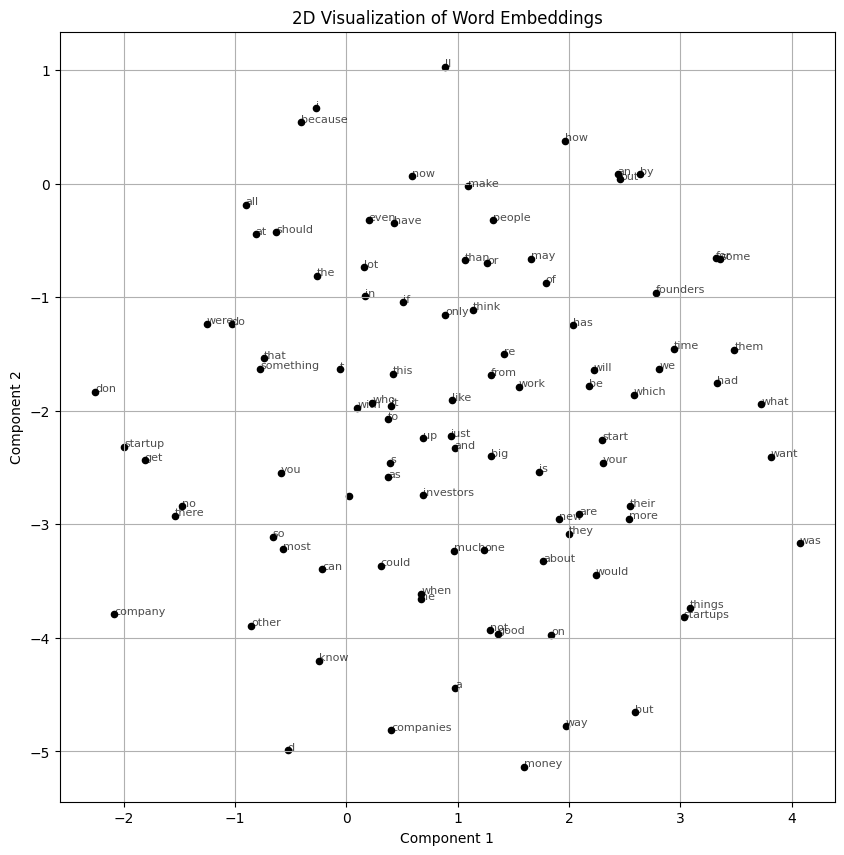

In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define larger embedding size for words
embedding_dim = 64
hidden_size = 1024
# Assuming you have a tokenizer or a vocabulary list
vocab_size = len(tokenizer.word_index) + 1  # +1 if padding index is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model and tensors to the device
embedding_layer = nn.Embedding(vocab_size, embedding_dim).to(device)

class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size=1024):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)  # Flatten the embedding output
        x = torch.sin(self.lin1(x))  # Apply activation
        x = self.lin2(x)  # Output logits for vocabulary size
        return x

# Function for training the model (pseudo-code, needs implementation)
def train_model(model, data_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in data_loader:  # Assuming data_loader yields (input, target) pairs
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Function to plot word embeddings
def plot_word_embeddings(model, tokenizer, num_words_to_visualize=100, perplexity=30.0):
    # Extract the embedding layer weights
    embeddings = model.emb.weight.detach().cpu().numpy()

    # Choose the indices of words to visualize
    word_indices = np.arange(1, min(vocab_size, num_words_to_visualize))
    selected_embeddings = embeddings[word_indices]

    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    # Plot the embeddings
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='k', s=20)  # Points color and size

    # Annotate the points with corresponding words
    for i, index in enumerate(word_indices):
        plt.annotate(tokenizer.index_word.get(index, '?'), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

    plt.title("2D Visualization of Word Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# Example model usage
model = NextWord(block_size, vocab_size, embedding_dim).to(device)
#model = torch.compile(model)

# Pseudo-code for preparing your data loader and criterion
# data_loader = ...
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model (implement the data loading part)
# train_model(model, data_loader, criterion, optimizer, num_epochs=10)

# Visualize the word embeddings after training
plot_word_embeddings(model, tokenizer)


In [21]:
def generate_sentence(model, tokenizer, block_size, max_len=10):
    # Initialize context with zeros, representing the start token (you may replace it with the actual start token index if needed)
    context = [0] * block_size  # Adjust this if you have a specific start token
    sentence = ''

    for i in range(max_len):
        # Prepare the input tensor from the context
        x = torch.tensor(context).view(1, -1).to(device)  # Ensure input tensor is on the same device as the model

        # Forward pass to get predictions
        with torch.no_grad():  # Disable gradient calculation for inference
            y_pred = model(x)  # Get predictions from the model

        # Sample from the distribution
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()  # Sample from distribution

        # Convert index to word using the tokenizer
        word = tokenizer.index_word.get(ix, '?')  # Get word or default to '?'

        # Check for end token to stop generation
        if word == '<end>':  # Replace with your actual end token if needed
            break

        sentence += (word + ' ')  # Append the word to the sentence

        # Update context for the next word
        context = context[1:] + [ix]  # Update context with the new index

    return sentence.strip()  # Return the generated sentence


In [22]:
# Example of generating multiple sentences
for i in range(10):
    generated_sentence = generate_sentence(model, tokenizer, block_size, max_len=10)
    print(f"Generated Sentence {i + 1}: {generated_sentence}")


Generated Sentence 1: collison and devoting consumed belonged civilization parentheses pests viewing recognized
Generated Sentence 2: axiom stress abuses f7n seems hamper august utopia curl weren
Generated Sentence 3: fashion adams sumerian f21n independent explictly knuth abandoning 75eldorado occurs
Generated Sentence 4: peers habit dissuaded vetoes metafacts ludendorff zealots cord kudzu heads
Generated Sentence 5: candor monroeville violent kicked airbed sayings charismatic rewrite vanished serviceable
Generated Sentence 6: broad giants captains velcro unequal concern duplicates sparsely intimately new
Generated Sentence 7: dispel honest amounted meet rent downward typed z laying perhapses
Generated Sentence 8: 1950s delaying axioms draws bars grownups balconies peasant suing learn
Generated Sentence 9: mobility libraries dotted set differ testimony express berners flimsy low
Generated Sentence 10: upstairs sipb guinea bluster rope uncannily stupidly circumspect ages indiana


In [23]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

emb.weight torch.Size([16288, 64])
lin1.weight torch.Size([1024, 320])
lin1.bias torch.Size([1024])
lin2.weight torch.Size([16288, 1024])
lin2.bias torch.Size([16288])


In [24]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Training loop
batch_size = 4096
print_every = 100
elapsed_time = []
g=torch.Generator()
g.manual_seed(4000002)

for epoch in range(800):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        x = x.to(device)  # Ensure input tensor is on the same device as the model
        y = y.to(device)  # Ensure target tensor is also on the same device
        # Forward pass
        y_pred = model(x)

        # Compute loss
        loss = loss_fn(y_pred, y)

        # Backward pass and optimization
        loss.backward()
        opt.step()
        opt.zero_grad()

    end_time = time.time()
    elapsed_time.append(end_time - start_time)

    # Print progress at intervals
    if epoch % print_every == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Time: {elapsed_time[-1]:.2f} sec")

Epoch 0, Loss: 5.5248, Time: 17.13 sec
Epoch 100, Loss: 0.7242, Time: 16.85 sec
Epoch 200, Loss: 0.6853, Time: 16.85 sec
Epoch 300, Loss: 0.6688, Time: 16.86 sec
Epoch 400, Loss: 0.6306, Time: 16.85 sec
Epoch 500, Loss: 0.6181, Time: 16.85 sec
Epoch 600, Loss: 0.5751, Time: 16.85 sec
Epoch 700, Loss: 0.5663, Time: 16.85 sec


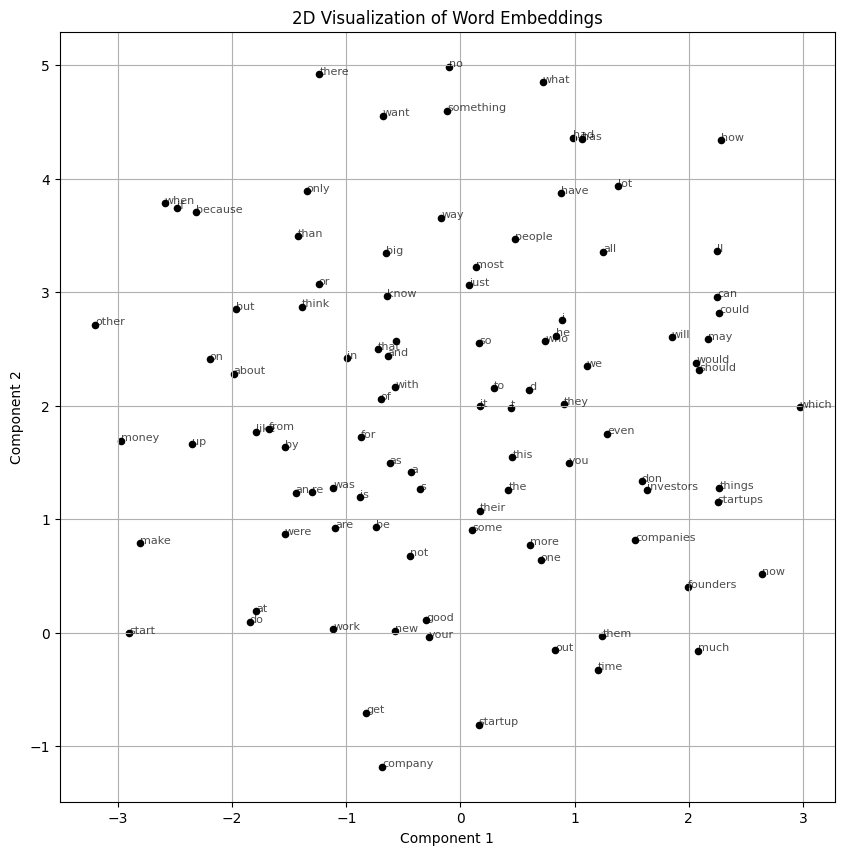

In [25]:
# Visualize the embedding

plot_word_embeddings(model, tokenizer)

In [26]:
# Example of generating multiple sentences
for i in range(10):
    generated_sentence = generate_sentence(model, tokenizer, block_size, max_len=10)
    print(f"Generated Sentence {i + 1}: {generated_sentence}")


Generated Sentence 1: what you re building right the bigger . it could
Generated Sentence 2: to do anything work on it a lot of investor
Generated Sentence 3: what you re building right in the sense ten we
Generated Sentence 4: what you re doing . then that if you want
Generated Sentence 5: that there are two components you care what to happens
Generated Sentence 6: what you re building really hard you should not to
Generated Sentence 7: the kind of work is more likely to be obsolete
Generated Sentence 8: what you re building really hard part . some companies
Generated Sentence 9: what you re building really hard part . it was
Generated Sentence 10: what you re building is so great that everyone who


In [27]:
import os

# Define directory to save models
model_dir = "/content/saved_models"
os.makedirs(model_dir, exist_ok=True)

# Save model with unique configurations
def save_model_variant(model, variant_name):
    torch.save(model.state_dict(), os.path.join(model_dir, f"{variant_name}.pt"))

# Example of saving model variants
save_model_variant(model, "embedding64_hidden1024")

In [28]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 7.8 MB/s eta 0:00:00


In [29]:
# Define the NextWord model and save it to model.py

code = """
# model.py
# model.py
import torch
import torch.nn as nn

class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size=1024):
        super(NextWord, self).__init__()
        self.block_size = block_size
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)  # Flatten the embedding output
        x = torch.sin(self.lin1(x))  # Apply activation
        x = self.lin2(x)  # Output logits for vocabulary size
        return x



"""

# Save code to model.py
with open("/content/model.py", "w") as file:
    file.write(code)

print("model.py created successfully!")

model.py created successfully!


In [30]:
# Define functions to save and load tokenizer, then save it to tokenizer.py

code = """
import pickle

def save_tokenizer(tokenizer, path='/content/tokenizer.pkl'):
    # Save the tokenizer to a file
    with open(path, 'wb') as f:
        pickle.dump(tokenizer, f)

def load_tokenizer(path='/content/tokenizer.pkl'):
    # Load the tokenizer from a file
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer
"""

# Save code to tokenizer.py
with open("/content/tokenizer.py", "w") as file:
    file.write(code)

print("tokenizer.py created successfully!")

tokenizer.py created successfully!


In [31]:
from tokenizer import save_tokenizer
save_tokenizer(tokenizer)

In [32]:
streamlit_code = '''
import streamlit as st
import torch
import numpy as np  # Import your model class from your code
from model import NextWord
from tokenizer import load_tokenizer  # Helper function to load tokenizer
import random

# Load tokenizer and word-index mapping
tokenizer = load_tokenizer()  # Function to load saved tokenizer object
stoi = tokenizer.word_index
itos = {i: w for w, i in stoi.items()}

# Load Model
@st.cache_resource  # Caches model to avoid reloading on each interaction

def load_model(variant_name, block_size, embedding_dim):
    model = NextWord(block_size=block_size, vocab_size=len(stoi) + 1, emb_dim=embedding_dim, hidden_size=1024)

    # Load the state dictionary, handling potential key mismatches
    state_dict = torch.load(f"/content/saved_models/{variant_name}.pt")

    # Remove '_orig_mod.' prefix from keys if present
    compatible_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('_orig_mod.'):
            compatible_state_dict[k[len('_orig_mod.'):]] = v
        else:
            compatible_state_dict[k] = v

    model.load_state_dict(compatible_state_dict)

    model.eval()  # Set model to evaluation mode
    return model







# User input
st.title("Next-Word Prediction")
user_input = st.text_input("Enter a sentence:", "The quick brown fox")
context_length = st.slider("Context Length", 1, 10, 5)
embedding_dim = st.selectbox("Embedding Dimension", [64])
variant = st.selectbox("Choose Model Variant", ["embedding64_hidden1024"])

# Update the call to load_model in the Streamlit app

model = load_model(variant, context_length, embedding_dim)
# Load the selected model


# Generate Prediction Function
def generate_prediction(model, input_text, max_len=10):
    tokens = tokenizer.texts_to_sequences([input_text])[0]

    context = [stoi.get('.', None)] * context_length  # Initialize context

    for token in tokens[-context_length:]:  # Populate context from user input
        context = context[1:] + [token]

    sentence = ""
    for _ in range(max_len):
        x = torch.tensor([context], dtype=torch.long)
        y_pred = model(x)
        ix = torch.distributions.Categorical(logits=y_pred).sample().item()
        word = itos.get(ix, "[UNK]")
        if word == '.':
            break
        sentence += word + " "
        context = context[1:] + [ix]  # Update context with predicted word
    return sentence.strip()

if user_input:
    prediction = generate_prediction(model, user_input)
    st.write("Generated Text:", prediction) '''

In [33]:
import streamlit as st
import torch
import numpy as np
from model import NextWord
from tokenizer import load_tokenizer  # Helper function to load tokenizer

# Load tokenizer and word-index mapping
tokenizer = load_tokenizer()  # Function to load saved tokenizer object
stoi = tokenizer.word_index
itos = {i: w for w, i in stoi.items()}

# Load Model
@st.cache_resource  # Caches model to avoid reloading on each interaction
def load_model(variant_name, block_size, embedding_dim):
    model = NextWord(block_size=block_size, vocab_size=len(stoi) + 1, emb_dim=embedding_dim, hidden_size=1024)

    # Load the state dictionary, handling potential key mismatches
    state_dict = torch.load(f"/content/saved_models/{variant_name}.pt", map_location=torch.device('cpu'))

    # Remove '_orig_mod.' prefix from keys if present
    compatible_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('_orig_mod.'):
            compatible_state_dict[k[len('_orig_mod.'):]] = v
        else:
            compatible_state_dict[k] = v

    model.load_state_dict(compatible_state_dict)
    model.eval()  # Set model to evaluation mode
    return model

# User input
st.title("Next-Word Prediction")
user_input = st.text_input("Enter a sentence:", "The quick brown fox")
context_length = st.slider("Context Length", 1, 10, 5)
embedding_dim = st.selectbox("Embedding Dimension", [64])
variant = st.selectbox("Choose Model Variant", ["embedding64_hidden1024"])

# New input for number of words to predict
k = st.number_input("Number of words to predict:", min_value=1, value=10, step=1)

# Load the selected model
model = load_model(variant, context_length, embedding_dim)

# Generate Prediction Function
def generate_prediction(model, input_text, num_words, max_len=10):
    tokens = tokenizer.texts_to_sequences([input_text])[0]

    context = [stoi.get('.', None)] * context_length  # Initialize context

    for token in tokens[-context_length:]:  # Populate context from user input
        context = context[1:] + [token]

    sentence = ""
    for _ in range(num_words):  # Use num_words instead of max_len
        x = torch.tensor([context], dtype=torch.long)
        y_pred = model(x)
        ix = torch.distributions.Categorical(logits=y_pred).sample().item()
        word = itos.get(ix, "[UNK]")
        if word == '.':
            break
        sentence += word + " "
        context = context[1:] + [ix]  # Update context with predicted word
    return sentence.strip()

if user_input:
    prediction = generate_prediction(model, user_input, k)  # Pass k to generate_prediction
    st.write("Generated Text:", prediction)

2024-10-28 20:38:14.495 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-28 20:38:14.575 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-10-28 20:38:14.577 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-28 20:38:14.579 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-28 20:38:14.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-28 20:38:14.582 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-28 20:38:14.583 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-28 20:38:14.588 Session state does not 

In [34]:
# Save code to tokenizer.py
with open("/content/app.py", "w") as file:
    file.write(streamlit_code)

print("app.py created successfully!")



app.py created successfully!
